# PROJECT: Course Optimization for Data Science 2023-2024
## Optimization strategies for the multiclass multinomial logistic regression with non-smooth penalties


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the multinomial logistic regression model
- Implement your own solvers for L1, L2 and L1/L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for the multinomial logistic regression model and test it on the `digits` dataset.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 21st of January 2024 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "mohammed"
ln1 = "kafile"
fn2 = "mohamed"
ln2 = "khair"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_kafile_mohammed_and_khair_mohamed.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 0: Multinomial logistic regression model

This model is a multinomial logistic regression model. It is a supervised learning model, in the case where the target space $\mathcal{Y}$ is discrete: $\mathcal{Y}=\{1, \dots, K\}$; this is a multiclass classification model.

We consider a sample $x \in \mathbb{R}^{P}$ belonging to $K$ possible classes.

We want to solve the classification task, _i.e.,_ learn the parameters $\theta = (\mathbf{W}, \mathbf{b}) \in \mathbb{R}^{P\times K}\times \mathbb{R}^{K}$ of the function $f_\theta: \mathbb{R}^P \to [0, 1]^K$ which corresponds for each coordinate to the probability of being from one class.

The model is defined as
$$
[f_\theta(x)]_k = \mathbb{P}[Y=k | x] = \frac{1}{Z} \exp(w_k^\top x + b_k) \enspace ,
$$
where $w_k$ corresponds to the kth column of $W$, and $Z$ is a normalizing constant.

As these probabilities must sum to one, we get
$$
Z = \sum_{k=1}^K \exp(w_k^\top x + b_k).
$$
We can recognize the so-called _soft-max_ function: $[\sigma(z)]_i = \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}$.

After one-hot encoding of the target variable ([`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), denoting $\{ y_{ik} \}_{k=1}^{K}$ the indicator sequence for the class of the $i^{\text{th}}$ observation $x_i$ (i.e., if the sample $i$ belongs to class $k$, then $y_{ik} = 1$ and $y_{ik'}=0$ for $k'\neq k$) the negative log likelihood (**nll**, _a.k.a_ cross-enropy loss) becomes:
$$
L(W, b) = - \frac1N \sum_{i=1}^N \log(\mathbb{P}[Y=y_i | x_i]) = -\frac1N \sum_{i=1}^N \log\Bigg(\frac{\exp(w_{y_i}^\top x_i + b_{y_i})}{\sum_{k=1}^K \exp(w_k^\top x_i+ b_k)}\Bigg) \enspace .
$$

**Note:** The notation $w_{y_i}$ means the column of $W$ whose index corresponds to the class value (e.g. 1, 2, ..., K) for the sample $x_i$.

Using the softmax function, we can also rewrite this as
$$
L(W, b) =  -\frac1N \sum_{i=1}^N \log([\sigma(Wx_i + b)]_{y_i})
$$

Introducing some regularization on the parameter $W$ with parameter $\lambda \ge 0$, the penalized likelihood estimation problem is written:

$$
    (\mathcal{P}):
	\min_{W, b} \quad L(W, b) + \lambda \mathcal{R}(W)
$$

where $\mathcal{R}(W)$ can be :
- $\mathcal{R}_1(W) = \|W\|_1 = \sum_{j=1}^P \sum_k^K |W_{jk}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(W) = \tfrac{1}{2} \|W\|^2_F = \tfrac{1}{2} \sum_{j=1}^P \sum_{k=1}^K W_{jk}^2$, ie. a squared $\ell_2$ norm 
- $\mathcal{R}_{21}(W) = \|W\|_{21} = \sum_{j=1}^P \sqrt{\sum_{k=1}^K W_{jk}^2}$, ie. an $\ell_{21}$ mixed-norm. This corresponds to the $\ell_1$ norm of the sequence of $\ell_2$ norms of the rows of $W$.

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that $(\mathcal{P})$ is a convex problem for the 3 different choices of regularization.</li>
    </ul>
</div>

**Hint**: You can show that for $z\in\mathbb{R}^K$ and $1\leq j\leq K$, the function $z\to -\log(\sigma(z)_j)$ is convex.

As suggested at the hint we will prove firstly that for   $1\leq j \leq K$ z $\mapsto$ 
$\ln(\sigma(z)_j)$ is convex.

Let $1\leq j \leq K $ fixed, we denote $f_{j}(z)= -\ln(\sigma(z)_j)$.

Since $\sigma(z)_j=\frac{\exp(z_j)}{\sum_{k=1}^{K} \exp(z_k)}  $

We have then $f_{j}(z)= -z_j+\ln(\sum_{k=1}^{K} \exp(z_k))$

if $l\neq j$ we have that $\frac{\partial f_j}{\partial z_l}=\frac{\exp(z_l)}{\sum_{k=1}^{K} \exp(z_k)}$

if $l=j$ we have that: $\frac{\partial f_j}{\partial z_j}= -1 + \frac{\exp(z_j)}{\sum_{k=1}^{K} \exp(z_k)}$

For second order derivatives:

If $l \neq p $, $\frac{\partial f_j}{\partial z_l \partial z_p}= \frac{-\exp(z_l)\cdot\exp(z_p)}{(\sum_{k=1}^{K} \exp(z_k))^2}$

If $l = p $, $\frac{\partial f_j}{\partial z_l^2}= \frac{\  exp(z_l)\cdot ((\sum_{k=1}^{K} \exp(z_k))-\exp(z_l))}{(\sum_{k=1}^{K} \exp(z_k))^2}$

If we put $t_i=\frac{\exp(z_i)}{\sum_{k=1}^{K} \exp(z_k)}$, the second order derivatives become:

If $l \neq p $, $\frac{\partial f_j}{\partial z_l \partial z_p}= -t_l\cdot t_p $

If $ l=p $, $\frac{\partial f_j}{\partial z_l^2}= t_l\cdot (1-t_l) $ 

To show that $f_j$ is convex we need to prove that the quantity $ X^T \cdot \nabla^2 f_j(z) \cdot X $ is positive. 

We have that $ X^T \cdot \nabla^2 f_j(z) \cdot X  =  \sum_{i=1}^{K} t_i\cdot(1-t_i)\cdot X_i^2 - \sum_{i \neq j} t_i \cdot t_j \cdot X_i \cdot X_j $

$(\sum_{i=1}^{K} t_i\cdot X_i)^2=\sum_{i=1}^{K} t_i^2\cdot X_i^2 + \sum_{i \neq j} t_i \cdot t_j \cdot X_i \cdot X_j $

$(\sum_{i=1}^{K} t_i\cdot X_i)^2 = - \sum_{i=1}^{K} t_i\cdot(1-t_i)\cdot X_i^2 +  \sum_{i \neq j} t_i \cdot t_j \cdot X_i \cdot X_j + \sum_{i=1}^{K} t_i \cdot X_i^2$

Hence:

$(\sum_{i=1}^{K} t_i\cdot X_i)^2 = - X^T \cdot \nabla^2 f_j(z) \cdot X + \sum_{i=1}^{K} t_i \cdot X_i^2$ 

By Cauchy-Schwartz Inequality:

$(\sum_{i=1}^{K} t_i \cdot X_i^2) \cdot (\sum_{i=1}^{K} t_i) \geq (\sum_{i=1}^{K} t_i\cdot X_i)^2 $

Since $\sum_{i=1}^{K} t_i = 1$ we get that: 

$\sum_{i=1}^{K} t_i \cdot X_i^2 \geq (\sum_{i=1}^{K} t_i\cdot X_i)^2 $

We conclude using the equation above that: $X^T \cdot \nabla^2 f_j(z) \cdot X \geq 0 $, hence $f_j(z)$ is convex.

$ W,b \mapsto W \cdot x_i + b $ is convex in W and b, and since $ 1 \leq y_i \leq K $ by composition of convex functions $ W,b \mapsto -\ln(\sigma(W \cdot x_i + b)_{y_i}) $ is convex.

The sum of convex functions is convex, hence $-\frac{1}{N} \cdot \sum_{i=1}^{N}\ln(\sigma(W \cdot x_i + b)_{y_i}) $ is convex with respect to W and b, which proves that $ W,b \mapsto L(W,b) $ is convex.

For the 3 different choices of regularization the chosen norm are convex, thus the sum of the loss $L(W,b)$ which is convex and the regularization term is convex.

Thus P is a convex problem for the 3 different choices of regularization.

## Simulation

Let's first generate data under the above model, with $K=3$ classes.

In [3]:
from sklearn.preprocessing import OneHotEncoder

def plot_data(X, y, U=None, ax=None):
    if y.ndim == 1:
        y = OneHotEncoder().fit_transform(y[:, None]).toarray()
    n_classes = y.shape[1]
    class_colors = plt.get_cmap('viridis', n_classes)(range(n_classes))
    # Display the result in ax, which is created if it does not exist.
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(X[:, 0], X[:, 1], c=y @ class_colors)

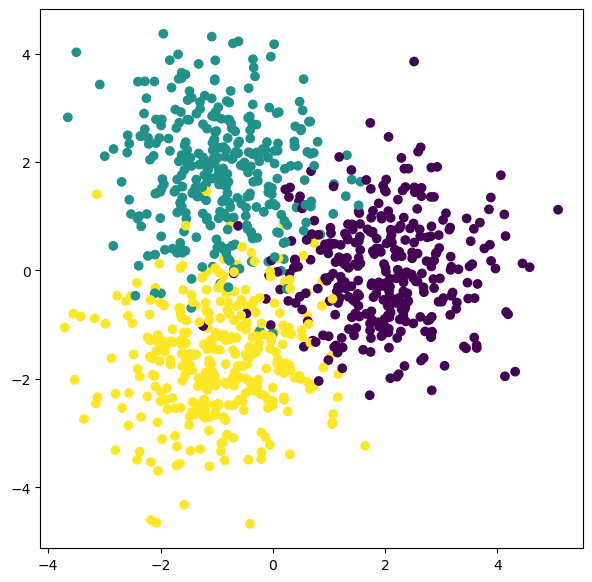

In [4]:
from sklearn.datasets import make_blobs

MU1 = (2, 0)
MU2 = (-1, np.sqrt(3))
MU3 = (-1, -np.sqrt(3))

centers = [MU1, MU2, MU3]
K = len(centers)  # number of classes
N = 1000

X, y_true = make_blobs(N, centers=centers, random_state=42)

plot_data(X, y_true)

In [5]:
# One-hot encoded target
Y = OneHotEncoder().fit_transform(y_true[:, None]).toarray()
Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Given some random values for $W$ and $b$, we want to compute the quantity $P(Y = k \mid x_i)$ for $k= 1, \dots , K$, and $i= 1, \dots, n$.

Note that in order to predict the label of $x$, we take the arg-maximum of the softmax values.

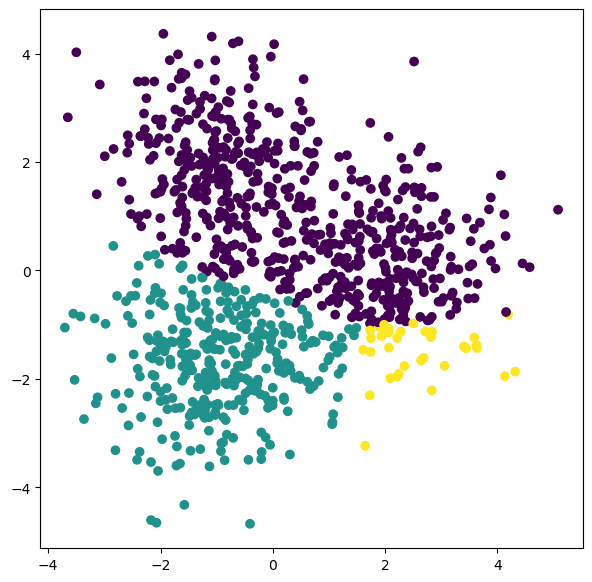

In [6]:
from scipy.special import softmax

rng = np.random.RandomState(42)
P = 2
W = rng.randn(P, K)
b = rng.randn(K)
y_proba_ = softmax(X @ W + b, axis=1)
y_ = np.argmax(y_proba_, axis=1)

plot_data(X, y_)

Note, that the sum of all probabilites for each sample is 1:

In [7]:
np.testing.assert_allclose(np.sum(y_proba_, axis=1), np.ones(N))

# Log-Likelihood function

Following the parametrization from $(\mathcal{P})$, one has `K + K*P` parameters.
We denote the stacked vector of all parameters `params`. The first `K` entries in `params` are the b and the last `K*P` entries correspond to $W$. The function that predicts the probabilities of each sample reads:

In [8]:
def predict_proba(params, X=X):
    """Compute the probability of each sample in X.
    
    Parameters:
    -----------
    params: array, shape (K + K * P,)
        Parameters of the model. The first K entries are the beta_k,
        the remaining K * P ones are the entries of W.

    X: array, shape (N, P)
        The features.

    Returns
    -------
    proba : ndarray, shape (N, K)
        The proba of belonging to each class for each sample.
    """
    _, P = X.shape
    K = params.size // (1 + P)
    b = params[:K]
    W = params[K:].reshape(P, K)
    return softmax(X @ W + b, axis=1)

The negative log-likelihood then reads:

In [9]:
def negloglik(params, X=X, Y=Y):
    Y_proba = predict_proba(params, X)
    loss = -np.log(Y_proba[Y == 1]).mean()
    return loss

params = np.concatenate([b, W.ravel()])
negloglik(params)

2.138083050969259

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>Can you apply coordinate descent or proximal gradient descent to $(\mathcal{P})$? Justify your answer with mathematical arguments and theoretical results from the course. No coding yet!</li>
    </ul>
</div>

$\textbf{Coordinate gradient descent:}$

Since the function L is convex and $ \frac{\sigma_{max}^{2}}{4N}$- Smooth, then $\nabla$L is Lipschitz continuous. Furthermore, we can establish the existence of a minimizer for the problem incorporating all regularization terms, given that the involved functions are convex and coercive.

However, it's important to note that $R_2$ is the only function among all the mentioned regularization terms that is smooth. This implies that it's necessary to compute the proximal operators for the other non-smooth terms.

Considering the matrix-based optimization in our case, it's important to highlight that the non-smooth terms $R_1$ and $R_{21}$ cannot be separated when examining their individual entries. As a result, we need to arrange them row-wise to achieve separability in the problem. Subsequently, we can utilize either block coordinate descent to address the $R_2$ regularized problem or employ proximal block coordinate descent for $R_1$ and $R_{21}$.

$\textbf{Proximal gradient descent:}$

Employing Proximal Gradient Descent to tackle the minimization problem encompassing all regularization terms is feasible due to the following reasons:
    
The loss function L is both smooth and convex.

All regularization terms are convex.

The computation of the proximal operator for our non-smooth regularization terms is straightforward.


INSERT YOUR ANSWER HERE

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
      <li>Propose solutions for the proximal operators for the 2 regularization functions: $\mathcal{R}_1(W)$ and $\mathcal{R}_2(W)$.</li>
    </ul>
</div>

For the regularization function $R_1(W)$ the proximal operator is defined by:

$prox_{\lambda \|\cdot\|_1} (W) = \arg\min_X {\lambda \|X||_1 + \frac{1}{2} \cdot \|X-W||_F ^2} $

For $  1 \leq i \leq P $ and $1 \leq j \leq K $, $ X_{ij}   \in W_{ij} - \lambda \cdot \partial{|X_{ij}|} $

If $ \lambda < W_{ij}$ then $ X_{ij} = W_{ij}-\lambda$ 

If $W_{ij} < -\lambda $ then $ X_{ij} = W_{ij}+\lambda$ 

If $ -\lambda \leq W_{ij} \leq \lambda $ then $X_{ij}=0$

$prox_{\lambda \|\cdot\|_1} (W)_{ij} =  sign(W_{ij}) \cdot max(0, |W_{ij}|-\lambda) $


For the regularization function $R_2(W)$ the proximal operator is defined by:

$prox_{\lambda \|\cdot\|_2} (W) = \arg\min_X {\frac{\lambda}{2} \cdot \|X||_F ^2 + \frac{1}{2} \cdot \|X-W||_F ^2} $

$X \in W - \frac{\lambda}{2}\cdot \partial{||X||_F^2}$

Hence $X\in W- \lambda \cdot X $

$X=\frac{1}{1+\lambda} \cdot W $

Thus: $prox_{\lambda \|\cdot\|_2} (W) = \frac{1}{1+\lambda} \cdot W $

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Justify that the prox for the regularization function $\mathcal{R}_{21}(W)$ is written:
$$
\mathrm{prox}_{\lambda R_{21}} (W) = Z \in \mathbb{R}^{P \times K} \quad \mathrm{where} \quad Z_{i, :} =\left(1 − \frac{\lambda}{\max(\|W_{i,:}\|_2, \lambda)}\right) W_{i, :}  \enspace .
$$
         </li>
    </ul>
</div>

The notation $W_{i, :} \in \mathbb{R}^K$ stands for the ith row of $W$.

Alternatively, we can write this as

$$
Z_{i, :} = \begin{cases} 0 \text{ if } \|W_{i, :}\|_2\leq \lambda \\
(\|W_{i, :}\|_2 - \lambda)\frac{W_{i, :}}{\|W_{i, :}\|_2} \text{ otherwise}
\end{cases}
$$

**HINT:** This proximal operator is called a block thresholding. You can check that the prox for $\mathcal{R}_{21}(W)$ and $\mathcal{R}_{1}(W)$ match with $K=1$.

The proximal operator for the regularization function $R_{21}(W)$ is defined by:

$prox_{\lambda \cdot R_{21}} (W) = \arg\min_X {\lambda \cdot \|X||_{21}  + \frac{1}{2} \cdot \|X-W||_F ^2} $

Let $ 1\leq i \leq P fixed $

If $||W_ {i,:}||$ $\leq $ $\lambda$, where $||W_ {i,:}||$ denotes the ith row of W. Suppose par absurd that $prox_{\lambda \cdot R_{21}} (W)_{i,:} \neq 0 $

For $ 1\leq j \leq K $ we have that $X_{ij} \in W_{ij} - \lambda \cdot \partial{||X_{ij}||_{21}} $, since the ith row of the prox is different from zero we have that $||X_{i,:}||\neq 0 $, hence $\partial{||X_{ij}||_{21}}=\frac{X_{ij}}{||X_{i,;||_2}}$, thus $W_{ij}= (1+\frac{\lambda}{||X_{i,:}||_2}) \cdot X_{ij} $, this equation holds for all $ 1 \leq j \leq K $. If we sum the $W_{ij}^2$ on all the columns we get that $ ||W_{i,:}||=(1+\frac{\lambda}{||X_{i,:}||}) \cdot ||X_{i,:}||_2 $, hence $||W_{i,:}||= ||X_{i,:}||_2 + \lambda $, and since $||W_ {i,:}||$ $\leq $ $\lambda$ we get that $||X_{i,:}||_2 \leq 0$, thus $||X_{i,:}||_2 = 0 $, which is absurd ! Hence $prox_{\lambda \cdot R_{21}} (W)_{i,:} = 0 $ if $||W_ {i,:}||$ $\leq $ $\lambda$.

If $||W_ {i,:}|| > \lambda$, by the same arguments we get that $||W_{i,:}||_2= ||X_{i,:}||_2 + \lambda $, hence $ W_{ij}=(1+\frac{\lambda}{||W_{i,:}||_2-\lambda})\cdot X_{ij}$, hence $X_{ij}=(||W_{i,:}||_2-\lambda)\cdot \frac{W_{ij}}{||W_{i,:}||_2}$, hence $X_{i,:} = (||W_{i,:}||_2-\lambda)\cdot \frac{W_{i,:}}{||W_{i,:}||_2}$, hence $prox_{\lambda \cdot R_{21}} (W)_{i,:} = (||W_{i,:}||_2-\lambda)\cdot \frac{W_{i,:}}{||W_{i,:}||_2} $.

Thus the ith row of the proximal operator can be resumed by the formula: $prox_{\lambda \cdot R_{21}} (W)_{i,:}=(1-\frac{\lambda}{max(||W_{i,:}||_2,\lambda)})\cdot W_{i,:} $.

Hence $prox_{\lambda \cdot R_{21}} (W)= Z $ where the ith row of Z, $Z_{i,:}$ is equal to $ (1-\frac{\lambda}{max(||W_{i,:}||_2,\lambda)})\cdot W_{i,:} $.

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Implement below the proximal operators for the 3 regularization functions: $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$ and $\mathcal{R}_{21}(W)$.</li>
    </ul>
</div>

(-1.0, 3.0)

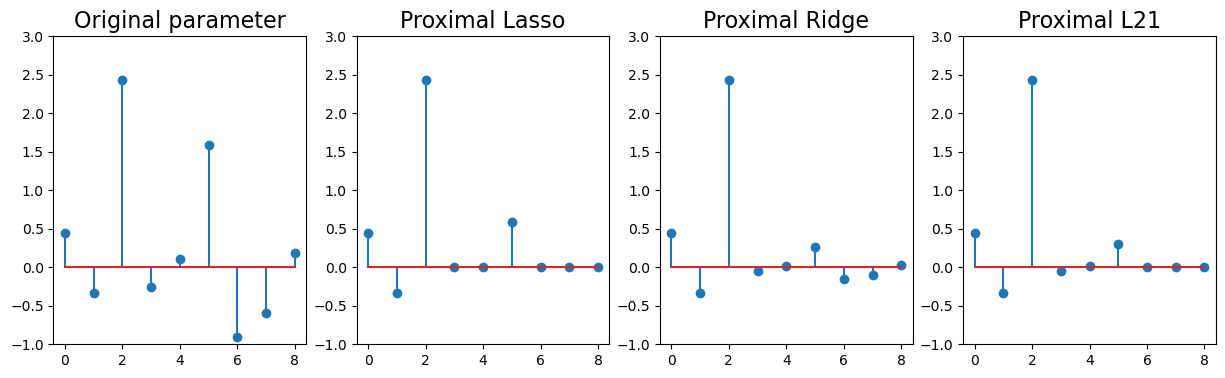

In [11]:
def prox_R2(params, reg=1., K=K):
    """Prox for R2 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    # TODO
    X=(1/(1+reg))*W
    X=X.ravel()
    params_=np.concatenate((b,X))
    # END TODO
    return params_

def prox_R1(params, reg=1., K=K):
    """Prox for R1 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    M=W.copy()
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            M[i][j]=np.copysign(1.0,W[i][j]) * max(0,np.abs(W[i][j])-reg)
    M=M.ravel()
    params_=np.concatenate((b,M))
    return params_

def prox_R21(params, reg=1., K=K):
    """Prox for R21 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)
    # TODO
    M=W.copy()
    for i in range(M.shape[0]):
        M[i,:]=(1-reg/max(np.linalg.norm(W[i,:]),reg))*W[i,:]
    M=M.ravel()
    params_=np.concatenate((b,M))
    return params_


rng = np.random.RandomState(5)
params = rng.randn((P + 1) * K)
l_l1 = 1.
l_l2 = 5.
l_l21 = 1.3
ylim = [-1, 3]

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 4, 1)
plt.stem(params)
plt.title("Original parameter", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 2)
plt.stem(prox_R1(params, l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 3)
plt.stem(prox_R2(params, l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 4)
plt.stem(prox_R21(params, l_l21))
plt.title("Proximal L21", fontsize=16)
plt.ylim(ylim)

**Note:** You see that the proximal operator does not affect the first 3 entries which correspond to the variable `b` which is not regularized.

## Part 1: Implementation of the solvers

### L-BFGS-B Solver

We will start by using the L-BFGS solver provided by `scipy`. To do this you will first propose a mathematical expression for the gradient of the cross-entropy loss (as implement in the `negloglik` function).

Propose an expression of the gradients of the loss $L(W, b)$ with respect to its two parameters:
        $\nabla_W L(W, b) \in \mathbb{R}^{P \times K}$ and $\nabla_b L(W, b) \in \mathbb{R}^{K}$.

<div class="alert alert-success">
    <b>QUESTION 6:</b>
    <ul>
    <li>
        Propose an expression of the gradients of the loss $L(W, b)$ with respect to its two parameters:
        $\nabla_W L(W, b) \in \mathbb{R}^{P \times K}$ and $\nabla_b L(W, b) \in \mathbb{R}^{K}$.
    </li>
    </ul>
</div>

The expression of the loss $L(W,b)$ is : $-\frac{1}{N} \cdot \sum_{i=1}^{N}\ln(\sigma(W \cdot x_i + b)_{y_i}) $.

For $ 1\leq i \leq N $ we define $ g_i(W,b)= - \ln(\sigma(W \cdot x_i + b)_{y_i})$

$g_i(W,b)= - <\omega_{y_{i}},x_i> - b_{y_{i}} + \log (\sum_{k=1}^K \exp(<\omega_k,x_i> + b_k))$

For $ 1 \leq l \leq P, \frac{\partial{g_i}}{\omega_{ly_i}}= - x_{li} + x_{li}\cdot \frac{exp(<\omega_{y_{i}},x_i>+ b_{y_{i}})}{\sum_{k=1}^K \exp(<\omega_k,x_i> + b_k)}$

Hence:

$\frac{\partial{g_i}}{\omega_{y_i}}= - x_{i} + x_{i}\cdot \frac{exp(<\omega_{y_{i}},x_i>+ b_{y_{i}})}{\sum_{k=1}^K \exp(<\omega_k,x_i> + b_k)}$

Thus:

$\frac{\partial{g_i}}{\omega_{y_i}}=(\frac{exp(<\omega_{y_{i}},x_i>+ b_{y_{i}})}{\sum_{k=1}^K \exp(<\omega_k,x_i> + b_k)}-1)\cdot x_{i} $

We show also that for $ j \neq y_{i}$ $\frac{\partial{g_i}}{\omega_{j}}=\frac{exp(<\omega_{j},x_i>+ b_{j})}{\sum_{k=1}^K \exp(<\omega_k,x_i> + b_k)}\cdot x_{j} $

Thus $\nabla_W g_i(W, b)= x_i \cdot (\hat{y_i}-1(y_i))^T $ where $\hat{y_i}$ is the vector of predicted probabilities for sample i and $1(y_i)$ is is a one-hot indicator vector for the true class of sample i. 

Hence $\nabla_W L(W, b)= \frac{1}{N} \cdot \sum_{i=1}^N x_i \cdot (\hat{y_i}-1(y_i))^T $

We show similary that: $\nabla_b L(W, b)= \frac{1}{N} \cdot \sum_{i=1}^N (\hat{y_i}-1(y_i))^T $

<div class="alert alert-success">
    <b>QUESTION 7:</b>
    <ul>
    <li>
        Implement the `negloglik_and_grad` function that returns the loss and its gradient.
    </li>
    </ul>
</div>

In [12]:
def negloglik_and_grad(params, X=X, Y=Y):
    """Negative Log-likelihood of the logistic regression model and gradient.

    Parameters
    ----------
    params: array, shape (K + K * P,)
        The parameters.
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.

    Returns
    -------
    loss : float
        log-likelihood of the logreg model
    grad : array, shape (K + K * P,)
        gradient of the model parameters
    """
    K = Y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W = params[K:].reshape(P, K)
    #####################
    N=X.shape[0]
    loss=0 
    grad_W=np.zeros(W.shape)
    grad_b=np.zeros(b.shape)
    for i in range(N):
        vec_i = Y[i,:]
        index = np.argmax(vec_i)
        w_i = W[:,index]
        b_i = b[index]
        loss += -1/N * np.log(np.exp(w_i.T @ X[i,:]+ b_i) / sum(np.exp(W[:,k].T @ X[i,:]+b[k]) for k in range(K)))
        y_hat_i = np.array([np.exp(W[:,l].T @ X[i,:]+ b[l])/sum(np.exp(W[:,k].T @ X[i,:]+b[k]) for k in range(K)) for l in range(K)])
        grad_W += (1/N) * (X[i,:].reshape(P,1)) @ ((y_hat_i-Y[i,:]).reshape(1,K))
        grad_b += (1/N) * (y_hat_i-Y[i,:])
        
    grad=np.vstack((grad_b, grad_W)).ravel()
    #####################
    return loss, grad

You can check your solution with the following code:

In [13]:
from scipy.optimize import check_grad

rng = np.random.RandomState(42)

for _ in range(10):
    x0 = rng.randn((P+1)*K)
    loss1 = negloglik(x0)
    loss2, grad = negloglik_and_grad(x0)
    np.testing.assert_allclose(loss1, loss2)
    grad_error = check_grad(
        lambda x: negloglik_and_grad(x)[0],
        lambda x: negloglik_and_grad(x)[1],
        x0=x0
    )
    print(grad_error)
    assert grad_error < 1e-5

1.259016814597295e-07
8.25043504110727e-07
1.5925177294441436e-07
5.055404358512331e-07
6.55032372512594e-07
4.361613349696902e-07
4.945164744020302e-07
5.305204003119165e-07
6.7763425877912e-07
1.116491080993815e-06


<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Solve the optimization using the `fmin_l_bfgs_b` function without any regularization.
    </li>
    </ul>
</div>

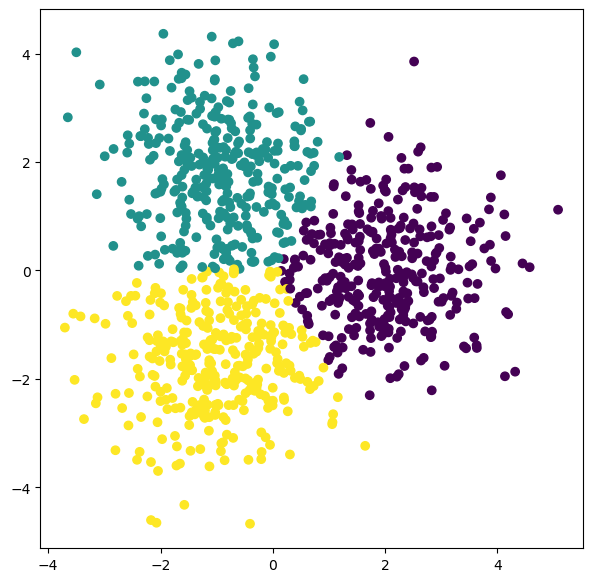

In [14]:
from scipy.optimize import fmin_l_bfgs_b

# TODO
rng = np.random.RandomState(42)
x0 = rng.randn((P+1)*K)
results = fmin_l_bfgs_b(negloglik_and_grad, x0)
params_hat = results[0]

# END TODO

y_proba = predict_proba(params_hat)
plot_data(X, np.argmax(y_proba, axis=1))

In [15]:
! pip install utils

In [16]:
from functools import partial
from utils import show_decision_boundary
show_decision_boundary(partial(predict_proba, params=params_hat), data=(X, Y))

ImportError: cannot import name 'show_decision_boundary' from 'utils' (C:\Users\hp\anaconda3\Lib\site-packages\utils\__init__.py)

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Wrap this into a function of X, Y and lbda that implements
        the function `multinomial_lbfgs_l2` (Based on $\mathcal{R}_2$ regularization) that will be
        used to get a good value of x_min (minimum of the $\ell_2$ regularized
        model).
    </li>
    </ul>
</div>

To help you we give you the code of the objective to minimize
in case you use $\ell_1$, $\ell_2$ and $\ell_{21}$ penalties.

In [17]:
def pobj_l1(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.sum(np.abs(W))


def pobj_l2(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda / 2 * np.linalg.norm(W, 'fro') ** 2


def pobj_l21(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.linalg.norm(W, axis=1).sum()

In [18]:
def multinomial_lbfgs_l2(X, Y, lbda=1):
    """Minimize the pobj_l2 function using L-BFGS
    
    Parameters
    ----------
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.
    lbda : float
        The regularization strength.

    Returns
    -------
    params_hat: array, shape (K + K * P,)
        The estimated parameters.
    """
    # TODO
    rng = np.random.RandomState(42)
    x0 = rng.randn((P+1)*K)
    results = fmin_l_bfgs_b(pobj_l2, x0, args=(X, Y, lbda), approx_grad=True)
    params_hat=results[0]
    # END TODO
    return params_hat

multinomial_lbfgs_l2(X, Y, lbda=0.01)

array([ 0.23563052,  0.34943574,  0.42106994,  1.59712993, -0.78550225,
       -0.81159831, -0.01989363,  1.32662642, -1.30667998])

Now that we have a gradient of the negative loglikelihood term we can implement other solvers. Namely you are going to implement:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

**Note:** Below, and following standard optimization notations, we will refer to the parameters of the optimization problem as `x`,  `x_min` and `x_init` for simplicity.

In [19]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        if monit.x_min is not None:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")
        else:
            ax1.set_ylabel("$f(x_k)$")
        ax1.set_xlabel("Epoch")
        ax1.set_title("Objective")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Iterates")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 10a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method
    </li>
    </ul>
</div>

The parameter `step` is the size of the gradient step.

In [20]:
def pgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : ndarray
        Here the params of shape (K + K*P,)
    grad : callable
        The gradient function.
    prox : callable
        The proximal operator function.
    n_iter : int
        The number of iterations
    step : float
        The step size.
    grad_args : tuple
        Extra parameters to pass to the gradient function
        (eg. X, Y)
    prox_args : tuple
        Extra parameters to pass to the prox function
        (eg. lbda, K)
    
    Returns
    -------
    x_hat : ndarray
        The estimated params.
    x_list : list
        The list of iterates values at each iteration.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        gradient=grad(x,*grad_args)
        x=prox(x-step*gradient,*prox_args)
        ### END TODO
        x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 10b:</b>
    <ul>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

**Note:** You will have to provide a `step` value, which should be theoretially less than `1 / lipschitz_constant`. You will propose a value for it but you are not expected to provide a mathematical proof, unless you think it's a moral duty to give one...

To help you we give you the proximal operator functions for $\ell_1$, $\ell_2$ and $\ell_{21}$ regularized models.

In [21]:
def prox_l1(params, step, lbda, K):
    return prox_R1(params, reg=step * lbda, K=K)

def prox_l2(params, step, lbda, K):
    return prox_R2(params, reg=step * lbda, K=K)

def prox_l21(params, step, lbda, K):
    return prox_R21(params, reg=step * lbda, K=K)

Let's first consider the $\ell_2$ case. You will use the `multinomial_lbfgs_l2` function to obtain a value for `x_min` so that you can display the convergence error on the iterates (ie. $\|x_k - x^*\|$). You will need to pass this `x_min` to the `monitor` function.

In [22]:
def grad_(params, X=X, Y=Y):
    """Negative Log-likelihood of the logistic regression model and gradient.

    Parameters
    ----------
    params: array, shape (K + K * P,)
        The parameters.
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.

    Returns
    -------
    loss : float
        log-likelihood of the logreg model
    grad : array, shape (K + K * P,)
        gradient of the model parameters
    """
    K = Y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W = params[K:].reshape(P, K)
    #####################
    N=X.shape[0]
    grad_W=np.zeros(W.shape)
    grad_b=np.zeros(b.shape)
    for i in range(N):
        y_hat_i = np.array([np.exp(W[:,l].T @ X[i,:]+ b[l])/sum(np.exp(W[:,k].T @ X[i,:]+b[k]) for k in range(K)) for l in range(K)])
        grad_W += (1/N) * (X[i,:].reshape(P,1)) @ ((y_hat_i-Y[i,:]).reshape(1,K))
        grad_b += (1/N) * (y_hat_i-Y[i,:])
        
    grad=np.vstack((grad_b, grad_W)).ravel()
    #####################
    return grad 

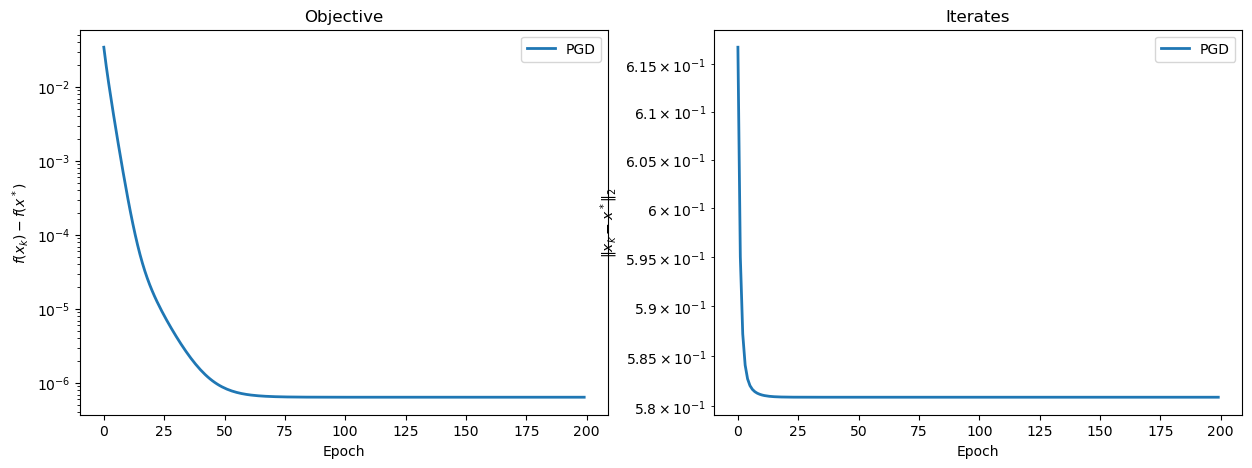

In [23]:
x_init = np.zeros((P + 1) * K)
n_iter = 200
lbda = .1

# TODO
x_min = multinomial_lbfgs_l2(X,Y,lbda)
step = (4*X.shape[0])/(linalg.norm(X, ord=2)**2)
#step=1
obj = negloglik
grad=grad_
prox=prox_l2
monitor_pgd_l2 = monitor(pgd, obj, x_min, (X, Y))
monitor_pgd_l2.run(x_init, grad, prox, n_iter, step, grad_args=(X, Y), prox_args=(step,lbda,K))

# END TODO

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

In [24]:
def multinomial_lbfgs_l1(X, Y, lbda=1):
    """Minimize the pobj_l2 function using L-BFGS
    
    Parameters
    ----------
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.
    lbda : float
        The regularization strength.

    Returns
    -------
    params_hat: array, shape (K + K * P,)
        The estimated parameters.
    """
    # TODO
    rng = np.random.RandomState(42)
    x0 = rng.randn((P+1)*K)
    results = fmin_l_bfgs_b(pobj_l1, x0, args=(X, Y, lbda), approx_grad=True)
    params_hat=results[0]
    # END TODO
    return params_hat

multinomial_lbfgs_l1(X, Y, lbda=0.01)

array([ 2.02405563e-01,  3.62493743e-01,  4.41240021e-01,  2.61601264e+00,
       -6.64820627e-09,  3.41692633e-04,  4.35366302e-04,  1.45579175e+00,
       -1.35035999e+00])

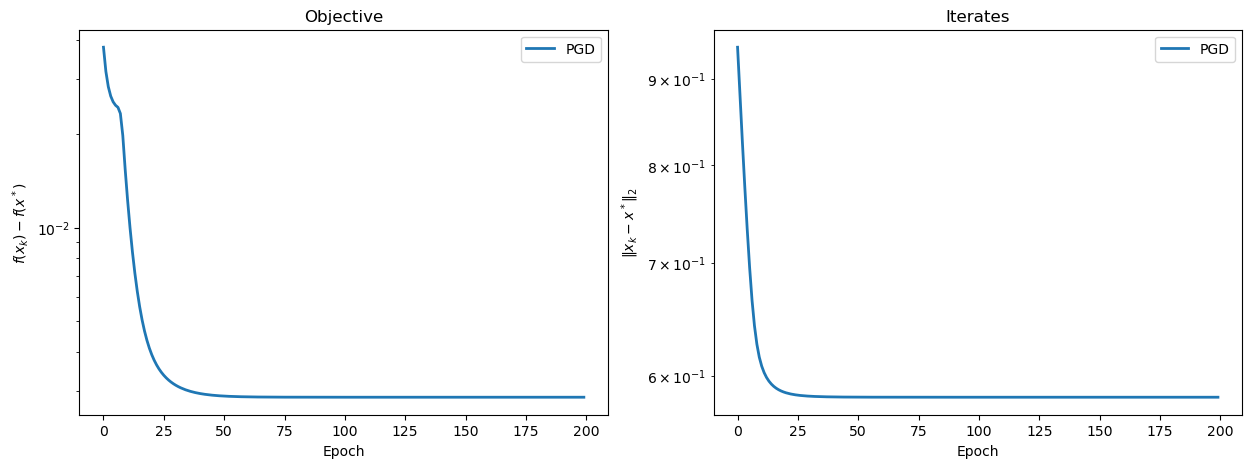

In [25]:
lbda = .1

# TODO
x_min = multinomial_lbfgs_l1(X,Y,lbda)
step = (4*X.shape[0])/(linalg.norm(X, ord=2)**2)
#step=1
obj = negloglik
grad=grad_
prox=prox_l1
monitor_pgd_l1 = monitor(pgd, obj, x_min, (X, Y))
monitor_pgd_l1.run(x_init, grad, prox, n_iter, step, grad_args=(X, Y), prox_args=(step,lbda,K))

# END TODO

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_{21}$ regularization:

In [26]:
def multinomial_lbfgs_l21(X, Y, lbda=1):
    """Minimize the pobj_l2 function using L-BFGS
    
    Parameters
    ----------
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.
    lbda : float
        The regularization strength.

    Returns
    -------
    params_hat: array, shape (K + K * P,)
        The estimated parameters.
    """
    # TODO
    rng = np.random.RandomState(42)
    x0 = rng.randn((P+1)*K)
    results = fmin_l_bfgs_b(pobj_l21, x0, args=(X, Y, lbda), approx_grad=True)
    params_hat=results[0]
    # END TODO
    return params_hat

multinomial_lbfgs_l21(X, Y, lbda=0.01)

array([ 0.2091788 ,  0.35903751,  0.43792247,  1.80236252, -0.89125885,
       -0.90968668, -0.02706786,  1.48124279, -1.45495239])

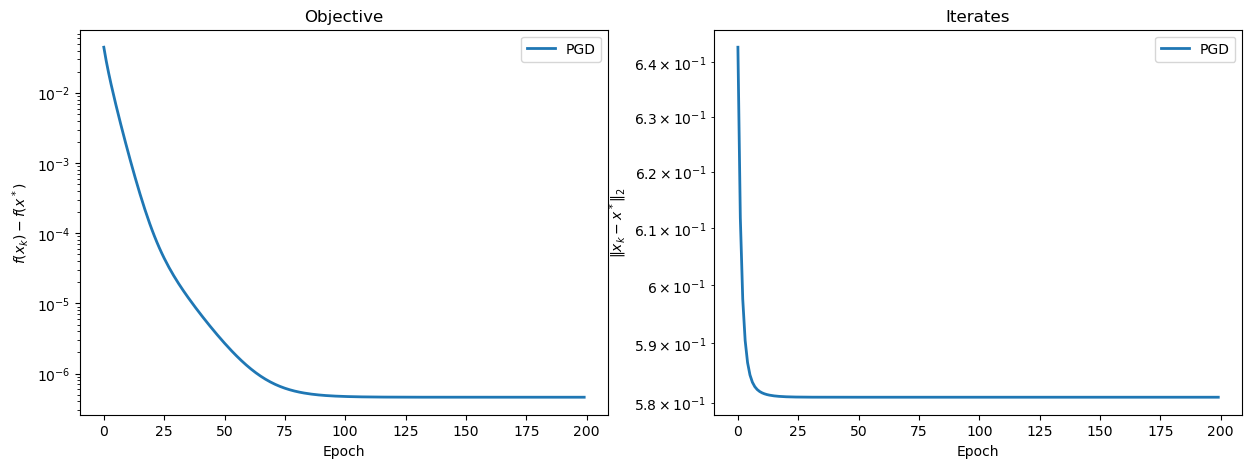

In [27]:
lbda = .1

# TODO
x_min = multinomial_lbfgs_l21(X,Y,lbda)
step = (4*X.shape[0])/(linalg.norm(X, ord=2)**2)
#step=1
obj = negloglik
grad=grad_
prox=prox_l21
monitor_pgd_l21 = monitor(pgd, obj, x_min, (X, Y))
monitor_pgd_l21.run(x_init, grad, prox, n_iter, step, grad_args=(X, Y), prox_args=(step,lbda,K))

# END TODO

monitors = [monitor_pgd_l21]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [28]:
def apgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        gradient=grad(x,*grad_args)
        t=(1+np.sqrt(1+4*t*t))*0.5
        y=x-step*gradient
        x=prox(y,*prox_args)
        ### END TODO
        x_list.append(x.copy())
    return x, x_list


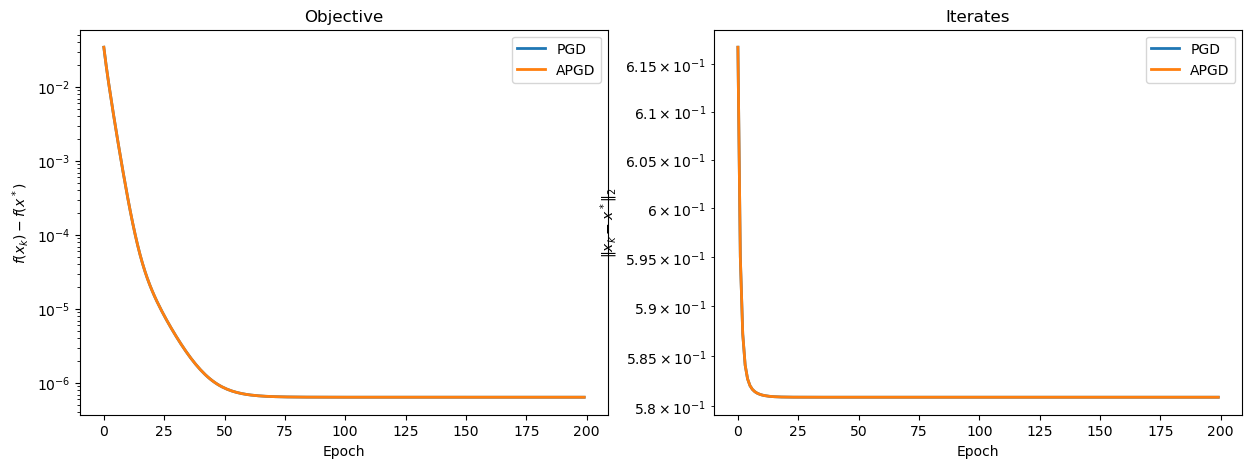

In [29]:
lbda = 0.1

# TODO
x_min = multinomial_lbfgs_l2(X,Y,lbda)
step = (4*X.shape[0])/(linalg.norm(X, ord=2)**2)
#step=1
obj = negloglik
grad=grad_
prox=prox_l2
monitor_apgd_l2 = monitor(apgd, obj, x_min, (X, Y))
monitor_apgd_l2.run(x_init, grad, prox, n_iter, step, grad_args=(X, Y), prox_args=(step,lbda,K))

# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

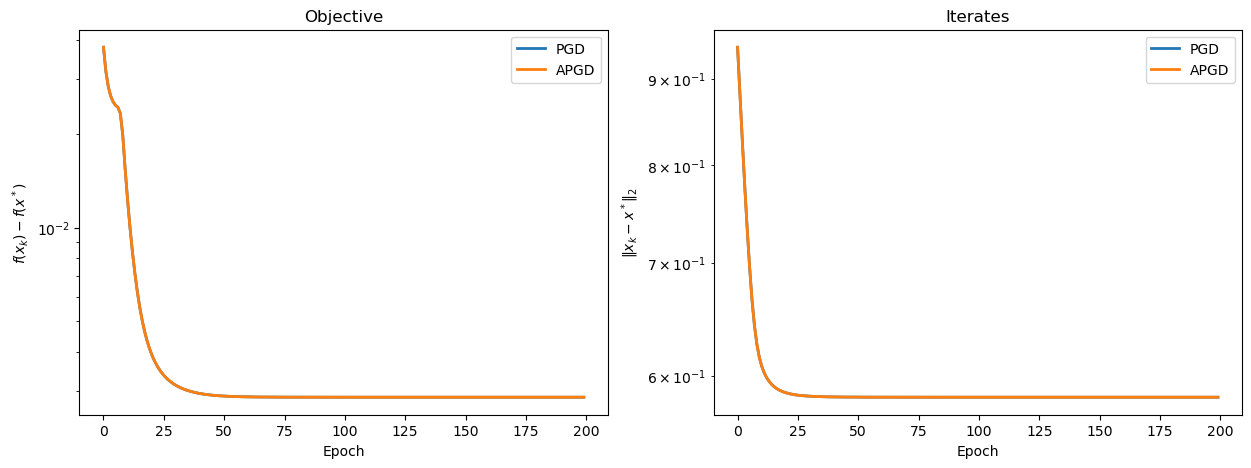

In [30]:
lbda = .1

# TODO
x_min = multinomial_lbfgs_l1(X,Y,lbda)
step = (4*X.shape[0])/(linalg.norm(X, ord=2)**2)
#step=1
obj = negloglik
grad=grad_
prox=prox_l1
monitor_apgd_l1 = monitor(apgd, obj, x_min, (X, Y))
monitor_apgd_l1.run(x_init, grad, prox, n_iter, step, grad_args=(X, Y), prox_args=(step,lbda,K))

# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

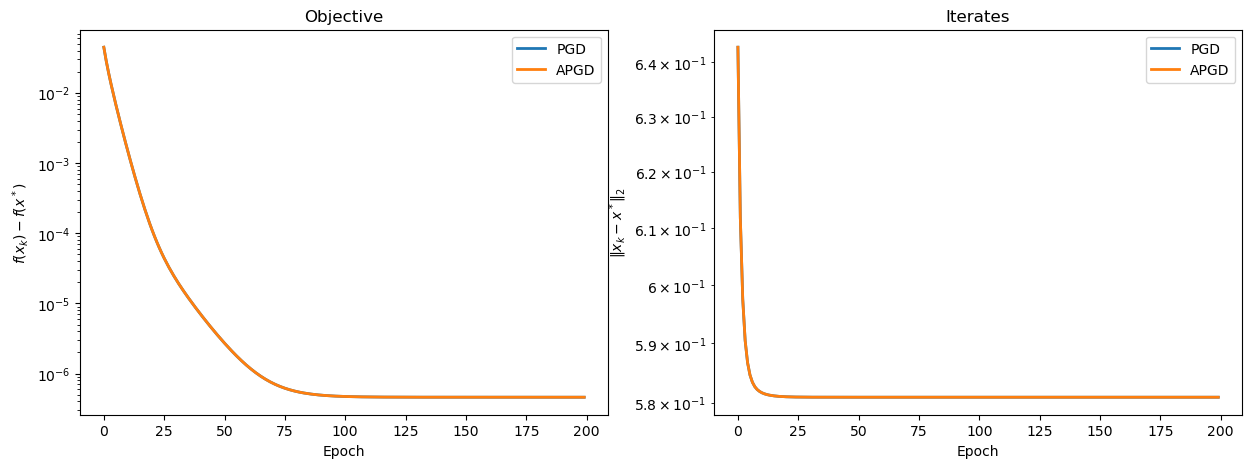

In [31]:
lbda = .1

# TODO
x_min = multinomial_lbfgs_l21(X,Y,lbda)
step = (4*X.shape[0])/(linalg.norm(X, ord=2)**2)
#step=1
obj = negloglik
grad=grad_
prox=prox_l21
monitor_apgd_l21 = monitor(apgd, obj, x_min, (X, Y))
monitor_apgd_l21.run(x_init, grad, prox, n_iter, step, grad_args=(X, Y), prox_args=(step,lbda,K))

# END TODO

monitors = [monitor_pgd_l21, monitor_apgd_l21]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

# Part 2: Application

You will now apply your solver to the `digits` dataset from scikit-learn

Let's first inspect the dataset:

In [32]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
X_digits.shape, y_digits.shape, np.unique(y_digits)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

Each row of X is an 8x8 image of digit:

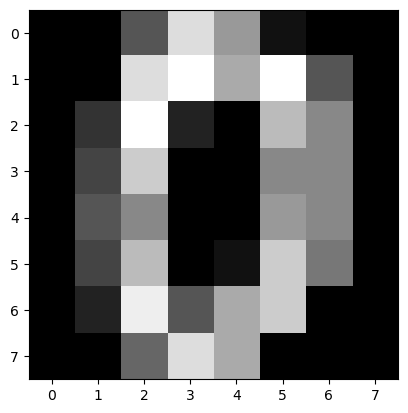

In [33]:
img = X_digits[0].reshape(8, 8)
plt.imshow(img, cmap="gray");

In order to highlight the importance of regularization and especially L1 we are going
to artificially add some random features with pure noise.

In [34]:
X = np.concatenate([X_digits, np.random.randn(len(X_digits), 1000)], axis=1)

Let's do a basic scaling of the features:

In [35]:
from sklearn.preprocessing import scale
X = scale(X)

Now test the functions above with this dataset:

In [77]:
x_init = np.zeros((X.shape[1] + 1) * np.unique(y_digits).size)
Y = OneHotEncoder().fit_transform(y_digits[:, None]).toarray()
print(negloglik(x_init, X=X, Y=Y))
print(negloglik_and_grad(x_init, X=X, Y=Y).shape)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 1797

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [50]:
from sklearn.base import BaseEstimator, ClassifierMixin


class MultinomialLogistic(BaseEstimator, ClassifierMixin):
    """scikit-learn estimator for the MultinomialLogistic model
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2' | 'l21'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'lbfgs'
        The type of regularization to use.
        'lbfgs' is only supported with penalty='l2'.
        
    Attributes
    ----------
    W_ : ndarray, shape (n_features, n_classes)
        The weights.
    b_ : ndarray, shape (n_classes,)
        The biases / intercepts.
    """
    def __init__(self, lbda=1., penalty='l2', max_iter=2000,
                 solver='lbfgs'):
        self.lbda = lbda
        self.penalty = penalty
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2', 'l21']
        assert self.solver in ['pgd', 'apgd', 'lbfgs'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target. Must be integers between 0 and n_classes - 1.
        """
        n_classes = int(np.max(y)) + 1
        assert np.all(np.unique(y) == np.arange(n_classes))
        Y = OneHotEncoder().fit_transform(y[:, None]).toarray()
        n_samples, n_features = X.shape
        # TODO
        def f(params):
            return negloglik(params, X, Y)
        
        def df(params):
            return negloglik_and_grad(params, X, Y)[1]
        
        params0=np.zeros((n_features+1)*n_classes)
        if self.solver == 'lbfgs':
            params, _, _ = fmin_l_bfgs_b(f, params0, df)
        
        elif self.solver == 'pgd':
            step = (4*X.shape[0])/(linalg.norm(X, ord=2)**2)
            grad_args = (X,Y)
            grad = lambda x,*g_args:negloglik_and_grad(x, *g_args)[1]
            if self.penalty == 'l1':
                prox = prox_l1
            elif self.penalty == 'l2':
                prox = prox_l2
            elif self.penalty == 'l21':
                prox = prox_l21
            prox_args = (step, self.lbda, n_classes)
            params, _ = pgd(params0, grad, prox, self.max_iter, step, grad_args, prox_args)
        
        elif self.solver == 'apgd':
            step = (4*X.shape[0])/(linalg.norm(X, ord=2)**2)
            grad_args = (X,Y)
            grad = lambda x,*g_args:negloglik_and_grad(x, *g_args)[1]
            if self.penalty == 'l1':
                prox = prox_l1
            elif self.penalty == 'l2':
                prox = prox_l2
            elif self.penalty == 'l21':
                prox = prox_l21
            prox_args = (step, self.lbda, n_classes)
            params, _ = apgd(params0, grad, prox, self.max_iter, step, grad_args, prox_args)
            
        W = params[n_classes:].reshape(n_features, n_classes)
        b = params[:n_classes]
        x = params
        # END TODO
        self.params_ = x
        self.W_ = W
        self.b_ = b
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        """Predict proba method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_proba : ndarray, shape (n_samples, n_classes)
            The predicted probabilities.
        """
        return predict_proba(self.params_, X)


In [39]:
for solver in ['pgd', 'apgd', 'lbfgs']:
    clf = MultinomialLogistic(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L2: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))
for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L1: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))
for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l21', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L21: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

KeyboardInterrupt: 

<div class="alert alert-success">
    <b>QUESTION 13:</b>
    <ul>
    <li>
        Compare the performance of your model on test data when varying
        the penalty among $\ell_2$, $\ell_1$ and $\ell_{21}$ for a grid of lambda values. Comment on what you see on the curves.
    </li>
    </ul>
</div>

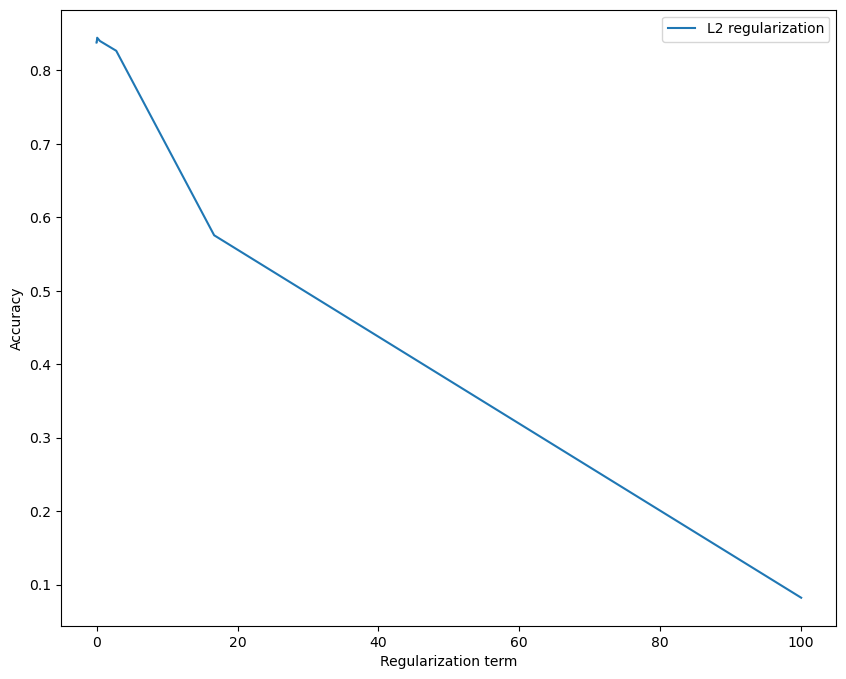

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_digits, random_state=42)
lbda_grid = np.geomspace(1e-5, 1e2, 10)

perf_l1=[]
perf_l2=[]
perf_l21=[]

# TODO
 
for lbda in lbda_grid:
    clf = MultinomialLogistic(lbda=lbda, penalty='l2', max_iter=100, solver='pgd')
    clf.fit(X_train, y_train)
    score=clf.score(X_test, y_test)
    perf_l2.append(score)
    
for lbda in lbda_grid:
    clf = MultinomialLogistic(lbda=lbda, penalty='l1', max_iter=100, solver='pgd')
    clf.fit(X_train, y_train)
    score=clf.score(X_test, y_test)
    perf_l1.append(score)

for lbda in lbda_grid:
    clf = MultinomialLogistic(lbda=lbda, penalty='l21', max_iter=100, solver='pgd')
    clf.fit(X_train, y_train)
    score=clf.score(X_test, y_test)
    perf_l21.append(score)

# END TODO

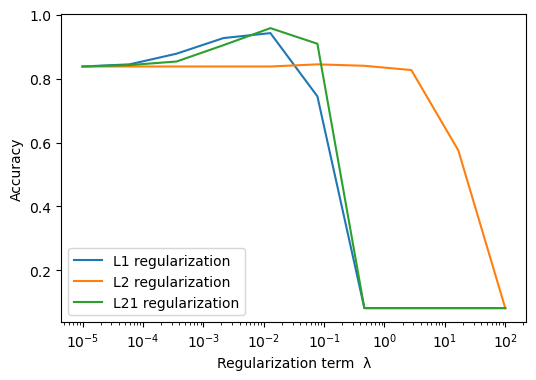

In [64]:
plt.figure(figsize = (6,4))
plt.xlabel('Regularization term  λ')
plt.ylabel('Accuracy')
plt.semilogx(lbda_grid, perf_l1, label='L1 regularization')
plt.semilogx(lbda_grid, perf_l2, label= 'L2 regularization')
plt.semilogx(lbda_grid, perf_l21, label='L21 regularization')
plt.legend()
plt.show()

For the l1 regularization the accuracy increases for the first values of λ but then the decay is very rapid and brutal. The accuracy become constant equals approximatively to 0.1. Indeed the l1 regularization shrinkes the coefficients toward 0, and the higher the penalization the higher the number of null coefficients. After a certain range of penalization all the coefficients become null and the model predicts a constant value, which affects the accuracy that become very low.

Concerning the l2 regularization the decay of accuracy is less rapid. For the first values of λ the accuracy remains almost constant, after the value of λ=7 the decay become very important. Indeed the l2 penalization shrinks the coefficients but doesn't completely cancel them.

And finally the l21 regularization, its curve has the quite same behavior as for the l1 regularization.

We note also that the highest accuracies are achieved with the l1 and l21 penalizations.

# Part 3 (bonus): Implement block-coordinate descent

<div class="alert alert-success">
    <b>QUESTION 14:</b>
    <ul>
    <li>
        Implement a proximal block-coordinate descent algorithm and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

**HINT:** The easiest way is to use block updates where you update iteratively for each pass over the data first `b` and then each row of `W`.

In [ ]:
### TODO

### END TODO